# Baseline Sentiment Analysis
Sentiment analysis of Indonesian online marketplace app reviews.

Steps:
1. EDA and data cleaning
2. Baseline model using traditional machine learning

## Loading Dependencies

In [1]:
import os
import re
from pathlib import Path
from joblib import dump

import pandas as pd

# Visualization
import seaborn as sns

# Google cloud
from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

/home/dionrickysptr/future-data-2/venv/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [3]:
query = """
SELECT * FROM `future-data-track-1.sapporo_mart.sampled_sentiment_analysis`;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [4]:
df.head()

,review,rating,sentiment
0,Ok siap,1,0
1,Banyak toko yg beralamat dijakarta eh ternyata...,1,0
2,"Payah payaaaaaaaaaahh!!! Udah terang"" dapet ba...",1,0
3,"Toko yg gajelas, gue pesen baju motif army dik...",1,0
4,Ngentod,1,0


## 1. EDA and cleaning

/home/dionrickysptr/future-data-2/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

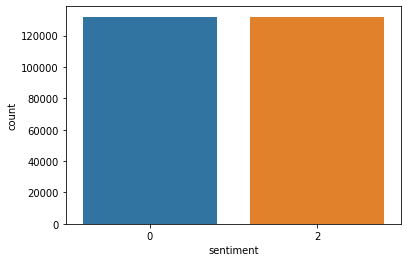

In [5]:
sns.countplot(df["sentiment"])

In [6]:
df.isna().sum()

review       0
rating       0
sentiment    0
dtype: int64

In [7]:
df = df.dropna(axis=0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264000 entries, 0 to 263999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     264000 non-null  object
 1   rating     264000 non-null  int64 
 2   sentiment  264000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.1+ MB


### Cleaning

In [9]:
def extract_emojis(sentence):
    return [word for word in sentence.split() if str(word.encode('unicode-escape'))[2] == '\\' ]

In [10]:
def preprocessing_text(texts):
    emojis = ' '.join(extract_emojis(texts))
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = texts.lower()

    return texts + emojis

In [11]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [12]:
df.head()

,review,rating,sentiment,review_cleaned
0,Ok siap,1,0,ok siap
1,Banyak toko yg beralamat dijakarta eh ternyata...,1,0,banyak toko yg beralamat dijakarta eh ternyata...
2,"Payah payaaaaaaaaaahh!!! Udah terang"" dapet ba...",1,0,payah payaaaaaaaaaahh udah terang dapet ba...
3,"Toko yg gajelas, gue pesen baju motif army dik...",1,0,toko yg gajelas gue pesen baju motif army dik...
4,Ngentod,1,0,ngentod


In [13]:
word_length = []
for row in df['review_cleaned']:
    word_length.append(len(row))

display(pd.DataFrame(word_length, columns=['word_length']).describe())
display(pd.DataFrame(word_length, columns=['word_length']).quantile(0.90))

,word_length
count,264000.000000
mean,69.577114
std,88.198770
min,1.000000
25%,12.000000
50%,36.000000
75%,92.000000
max,1734.000000


word_length    178.0
Name: 0.9, dtype: float64

In [14]:
df['sentiment'] = df['sentiment'].map({0:0, 2:1})

## Utils

In [15]:
def save(model_name, model_version, model, base_dir=None):
    model_dirname = '_'.join([model_name, '.'.join(map(str, model_version))])
    model_dirname = os.path.join(base_dir, model_dirname) if base_dir else model_dirname
    model_filename = model_dirname + '/saved_model.joblib'

    Path(model_dirname).mkdir(parents=True, exist_ok=True)

    dump(model, model_filename)

In [16]:
BASE_DIR = 'Sentiment Analysis/Baseline'

## Logistic Regression

              precision    recall  f1-score   support

           0       0.85      0.84      0.85     33142
           1       0.84      0.85      0.85     32858

    accuracy                           0.85     66000
   macro avg       0.85      0.85      0.85     66000
weighted avg       0.85      0.85      0.85     66000



<AxesSubplot:>

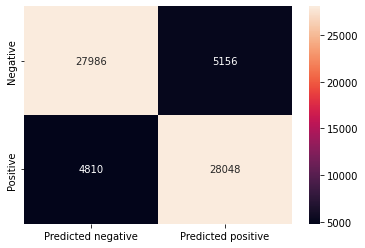

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'])
pipeline_lr = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_clf', LogisticRegression(max_iter=500))])
pipeline_lr.fit(X_train, y_train)

y_pred = pipeline_lr.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

In [21]:
MODEL_NAME = 'Baseline_LR_Sentiment'
MODEL_VERSION = (4, 0, 'E')

In [22]:
save(MODEL_NAME, MODEL_VERSION, pipeline_lr, BASE_DIR)

## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.82      0.77      0.79     32745
           1       0.79      0.83      0.81     33255

    accuracy                           0.80     66000
   macro avg       0.80      0.80      0.80     66000
weighted avg       0.80      0.80      0.80     66000



<AxesSubplot:>

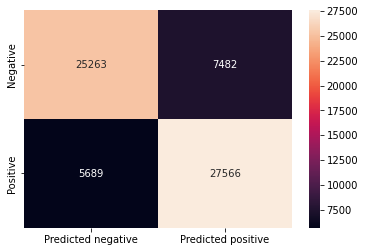

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'])
pipeline_dt = Pipeline([('tfidf', TfidfVectorizer()),
                    ('dt_clf', DecisionTreeClassifier())])
pipeline_dt.fit(X_train, y_train)

y_pred = pipeline_dt.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

In [21]:
MODEL_NAME = 'Baseline_DT_Sentiment'
MODEL_VERSION = (4, 0, 'E')

In [24]:
save(MODEL_NAME, MODEL_VERSION, pipeline_dt, BASE_DIR)

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     32949
           1       0.85      0.82      0.84     33051

    accuracy                           0.84     66000
   macro avg       0.84      0.84      0.84     66000
weighted avg       0.84      0.84      0.84     66000



<AxesSubplot:>

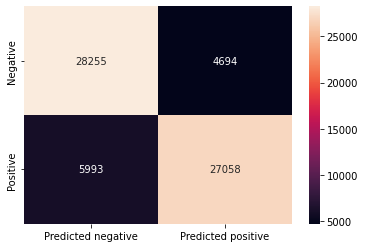

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'])
pipeline_rf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('rf_clf', RandomForestClassifier())])
pipeline_rf.fit(X_train, y_train)

y_pred = pipeline_rf.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

In [27]:
MODEL_NAME = 'Baseline_RF_Sentiment'
MODEL_VERSION = (4, 0, 'E')

In [28]:
save(MODEL_NAME, MODEL_VERSION, pipeline_rf, base_dir='Sentiment Analysis/ignore')

## SVM

In [29]:
from sklearn.svm import LinearSVC

              precision    recall  f1-score   support

           0       0.85      0.84      0.84     32928
           1       0.84      0.85      0.85     33072

    accuracy                           0.84     66000
   macro avg       0.84      0.84      0.84     66000
weighted avg       0.84      0.84      0.84     66000



<AxesSubplot:>

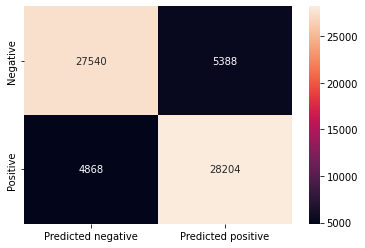

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'])
pipeline_svm = Pipeline([('tfidf', TfidfVectorizer()),
                    ('svm_clf', LinearSVC())])
pipeline_svm.fit(X_train, y_train)

y_pred = pipeline_svm.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

In [31]:
MODEL_NAME = 'Baseline_SVM_Sentiment'
MODEL_VERSION = (4, 0, 'E')

In [32]:
save(MODEL_NAME, MODEL_VERSION, pipeline_svm, BASE_DIR)

## Nearest Centroid

In [33]:
from sklearn.neighbors import NearestCentroid

              precision    recall  f1-score   support

           0       0.67      0.93      0.78     33033
           1       0.88      0.55      0.68     32967

    accuracy                           0.74     66000
   macro avg       0.78      0.74      0.73     66000
weighted avg       0.78      0.74      0.73     66000



<AxesSubplot:>

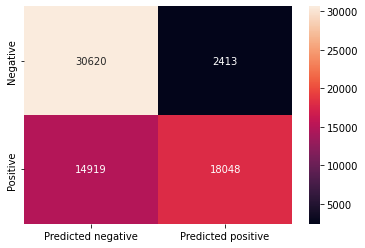

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'])
pipeline_nn = Pipeline([('tfidf', TfidfVectorizer()),
                    ('nn_clf', NearestCentroid())])
pipeline_nn.fit(X_train, y_train)

y_pred = pipeline_nn.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

In [35]:
MODEL_NAME = 'Baseline_NC_Sentiment'
MODEL_VERSION = (4, 0, 'E')

In [36]:
save(MODEL_NAME, MODEL_VERSION, pipeline_nn, BASE_DIR)

## Naive Bayes

In [37]:
from sklearn.naive_bayes import MultinomialNB

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     33118
           1       0.86      0.81      0.83     32882

    accuracy                           0.84     66000
   macro avg       0.84      0.84      0.84     66000
weighted avg       0.84      0.84      0.84     66000



<AxesSubplot:>

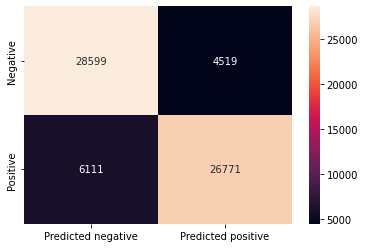

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'])
pipeline_nb = Pipeline([('tfidf', TfidfVectorizer()),
                    ('nb_clf', MultinomialNB())])
pipeline_nb.fit(X_train, y_train)

y_pred = pipeline_nb.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

In [39]:
MODEL_NAME = 'Baseline_NB_Sentiment'
MODEL_VERSION = (4, 0, 'E')

In [40]:
save(MODEL_NAME, MODEL_VERSION, pipeline_nb, BASE_DIR)

## KNeighbors

In [41]:
from sklearn.neighbors import KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.79      0.37      0.50     32914
           1       0.59      0.90      0.71     33086

    accuracy                           0.64     66000
   macro avg       0.69      0.64      0.61     66000
weighted avg       0.69      0.64      0.61     66000



<AxesSubplot:>

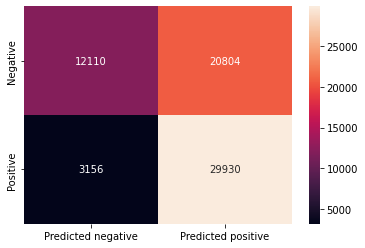

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'])
pipeline_knn = Pipeline([('tfidf', TfidfVectorizer()),
                    ('knn_clf', KNeighborsClassifier())])
pipeline_knn.fit(X_train, y_train)

y_pred = pipeline_knn.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

In [ ]:
MODEL_NAME = 'Baseline_KNN_Sentiment'
MODEL_VERSION = (4, 0, 'E')

In [ ]:
save(MODEL_NAME, MODEL_VERSION, pipeline_knn, BASE_DIR)